# INSTALLING AND IMPORTING LIBRARIES

In [ ]:
!apt install swig cmake

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (803 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 121913 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubunt

In [ ]:

!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit1/requirements-unit1.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 25.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of gymnasium[box2d] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 66.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none

In [ ]:
import gymnasium as gym
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from collections import namedtuple, deque
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.animation import ArtistAnimation
rc('animation', html='jshtml')

In [ ]:
env = gym.make("LunarLander-v2")
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [ ]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# DEFINING THE Q NETWORK

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size, seed=0, fc1_units=64, fc2_units=64):
        super(DQN,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# DEFINING THE REPLAYBUFFER

In [ ]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed,device):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

# DEFINING THE AGENT

In [ ]:
class Agent:
    def __init__(self, state_size, action_size, buffer_size, batch_size, gamma, tau, lr, update_every, seed, device="cuda"):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.device = device
        self.policy_network = DQN(state_size, action_size, seed).to(self.device)
        self.target_network = DQN(state_size, action_size, seed).to(self.device)
        self.optimizer = Adam(self.policy_network.parameters(), lr=lr)

        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed,device = device)
        self.t_step = 0
        self.update_every = update_every
        self.gamma = gamma
        self.tau = tau

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.memory.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.policy_network.eval()
        with torch.no_grad():
            action_values = self.policy_network(state)
        self.policy_network.train()
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        Q_targets_next = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.policy_network(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.policy_network, self.target_network, self.tau)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [ ]:
env.observation_space.shape[0]

8

In [ ]:
agent = Agent(state_size=env.observation_space.shape[0],
                  action_size=env.action_space.n,
                  buffer_size=int(1e5),
                  batch_size=64,
                  gamma=0.99,
                  tau=1e-3 ,
                  lr = 5e-4,
                  update_every = 4,
                  seed = 0,
                 device = "cuda")

# WRITING TRAINING LOOP

In [ ]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state,info = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, info,_ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=220.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.policy_network.state_dict(), 'checkpoint_lunar.pth')
            break
    return scores

In [ ]:
scores = dqn()

Episode 100	Average Score: -163.10
Episode 200	Average Score: -106.20
Episode 300	Average Score: -106.32
Episode 400	Average Score: -21.45
Episode 500	Average Score: 16.62
Episode 600	Average Score: 114.55
Episode 700	Average Score: 167.35
Episode 800	Average Score: 196.30
Episode 863	Average Score: 220.05
Environment solved in 763 episodes!	Average Score: 220.05


# RENDER IT

In [ ]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [ ]:
env.reset()
observation,info = env.reset()
fig,axes = plt.subplots()
done = False
rewards = 0
images = []
while not(done):
    action = agent.act(observation)
    observation, reward, done, info,_ = env.step(action)
    rewards+=reward
    image = axes.imshow(env.render(),animated = True)
    image.axes.set_xticks([])
    image.axes.set_yticks([])
    image.axes.set_title("Game")
    images.append([image])
plt.close(fig)
ani = ArtistAnimation(fig, images, interval=60, blit=True,repeat_delay=100)
ani

In [ ]:
ani.save('animation.mp4', writer='ffmpeg', fps=30)

# SCORE PLOT

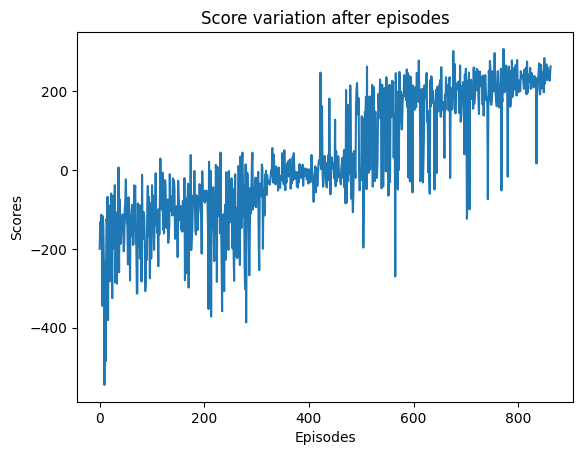

In [ ]:
fig,axes = plt.subplots(nrows = 1,ncols = 1)
plt.plot(scores)
plt.title("Score variation after episodes")
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.show()

# SAVING SCORES

In [ ]:
import pickle
with open("score_list.pkl","wb") as file_object:
  pickle.dump(scores,file_object)